In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
import optuna
from plotly.io import show

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split 

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

In [2]:
train = pd.read_csv('dataset_citrus/train.csv')
test = pd.read_csv('dataset_citrus/test.csv')
y_true = pd.read_csv('dataset_citrus/test_Y_true.csv')

train['name'] = np.where(train['name']=='grapefruit',0,1)
y_true = np.where(y_true =='grapefruit',0,1).reshape(-1)
train.head()

,name,diameter,weight,red,green,blue
0,0,11.60,199.71,153,59,16
1,0,10.25,178.06,148,54,14
2,0,11.99,205.39,133,72,2
3,1,7.63,139.91,152,82,2
4,1,7.43,137.10,158,78,3


In [3]:
X, y = train.drop(['name'],axis=1), train['name']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


In [4]:
def objective(trial):
    # Препроцессинг
    ## Список скалеров в препроцессинге
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust', 'normalizer', 'none'])

    ## Определение скалеров
    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    elif scalers == "robust":
        scaler = RobustScaler()
    elif scalers == "normalizer":
        scaler = Normalizer()
    else:
        scaler = 'passthrough'

    # Определяем модель машинного обучения
    ## количество соседей
    knn_n_neighbors=trial.suggest_int("knn_n_neighbors", 1, 100, step=1) 
    ## степень метрики миньковского
    knn_p = trial.suggest_int("knn_p", 1, 10, step=1)
    ## влияние растояния
    knn_weights=trial.suggest_categorical("knn_weights", ['uniform', 'distance'])

    estimator=KNeighborsClassifier(n_neighbors=knn_n_neighbors, p = knn_p, weights=knn_weights)

    # Собираем контейнер
    pipeline = make_pipeline(scaler, estimator)

    # Вычисляем средний результат на кроссвалидации
    cv_score = cross_val_score(pipeline, X, y, cv=7)
    score_mean = cv_score.mean()
    score_std = cv_score.std()
    return score_mean, score_std
    
study = optuna.create_study(directions=["maximize", "minimize"]) 
study.optimize(objective, n_trials=300, show_progress_bar=True)

[I 2025-02-19 14:08:13,450] A new study created in memory with name: no-name-15b09d0f-ce75-41f8-8ee5-8cbbc1ec43c7


  0%|          | 0/300 [00:00<?, ?it/s]

[I 2025-02-19 14:08:14,021] Trial 0 finished with values: [0.9238648195596648, 0.005687591309562411] and parameters: {'scalers': 'none', 'knn_n_neighbors': 49, 'knn_p': 9, 'knn_weights': 'distance'}.
[I 2025-02-19 14:08:14,853] Trial 1 finished with values: [0.926397922353021, 0.006143606022259835] and parameters: {'scalers': 'normalizer', 'knn_n_neighbors': 98, 'knn_p': 9, 'knn_weights': 'uniform'}.
[I 2025-02-19 14:08:15,626] Trial 2 finished with values: [0.927998064897601, 0.005914057379820871] and parameters: {'scalers': 'standard', 'knn_n_neighbors': 78, 'knn_p': 4, 'knn_weights': 'distance'}.
[I 2025-02-19 14:08:16,043] Trial 3 finished with values: [0.8983972942410795, 0.007945843722841711] and parameters: {'scalers': 'standard', 'knn_n_neighbors': 1, 'knn_p': 8, 'knn_weights': 'uniform'}.
[I 2025-02-19 14:08:16,802] Trial 4 finished with values: [0.925331948699878, 0.00483238412841431] and parameters: {'scalers': 'robust', 'knn_n_neighbors': 30, 'knn_p': 5, 'knn_weights': 'uni

In [20]:
study.best_trials

[FrozenTrial(number=156, state=1, values=[0.9267988289843301, 0.003096989866762657], datetime_start=datetime.datetime(2025, 2, 19, 14, 9, 57, 175277), datetime_complete=datetime.datetime(2025, 2, 19, 14, 9, 57, 493962), params={'scalers': 'normalizer', 'knn_n_neighbors': 30, 'knn_p': 4, 'knn_weights': 'distance'}, user_attrs={}, system_attrs={'nsga2:generation': 3}, intermediate_values={}, distributions={'scalers': CategoricalDistribution(choices=('minmax', 'standard', 'robust', 'normalizer', 'none')), 'knn_n_neighbors': IntDistribution(high=100, log=False, low=1, step=1), 'knn_p': IntDistribution(high=10, log=False, low=1, step=1), 'knn_weights': CategoricalDistribution(choices=('uniform', 'distance'))}, trial_id=156, value=None),
 FrozenTrial(number=160, state=1, values=[0.9278653003489954, 0.003438073134261476], datetime_start=datetime.datetime(2025, 2, 19, 14, 9, 59, 55101), datetime_complete=datetime.datetime(2025, 2, 19, 14, 9, 59, 906302), params={'scalers': 'robust', 'knn_n_nei

In [11]:
print(f"Number of trials on the Pareto front: {len(study.best_trials)}")

trial_with_highest_accuracy = max(study.best_trials, key=lambda t: t.values[0])
print("Trial with highest accuracy: ")
print(f"\tnumber: {trial_with_highest_accuracy.number}")
print(f"\tparams: {trial_with_highest_accuracy.params}")
print(f"\tvalues: {trial_with_highest_accuracy.values}")

Number of trials on the Pareto front: 11
Trial with highest accuracy: 
	number: 169
	params: {'scalers': 'minmax', 'knn_n_neighbors': 78, 'knn_p': 1, 'knn_weights': 'distance'}
	values: [0.9289320205694219, 0.004867290092514432]


In [28]:
trial_with_min_std = min(study.best_trials, key=lambda t: t.values[1])
print("Trial with highest accuracy: ")
print(f"\tnumber: {trial_with_min_std.number}")
print(f"\tparams: {trial_with_min_std.params}")
print(f"\tvalues: {trial_with_min_std.values}")

Trial with highest accuracy: 
	number: 239
	params: {'scalers': 'robust', 'knn_n_neighbors': 20, 'knn_p': 9, 'knn_weights': 'distance'}
	values: [0.9266656911520829, 0.002927340093015144]


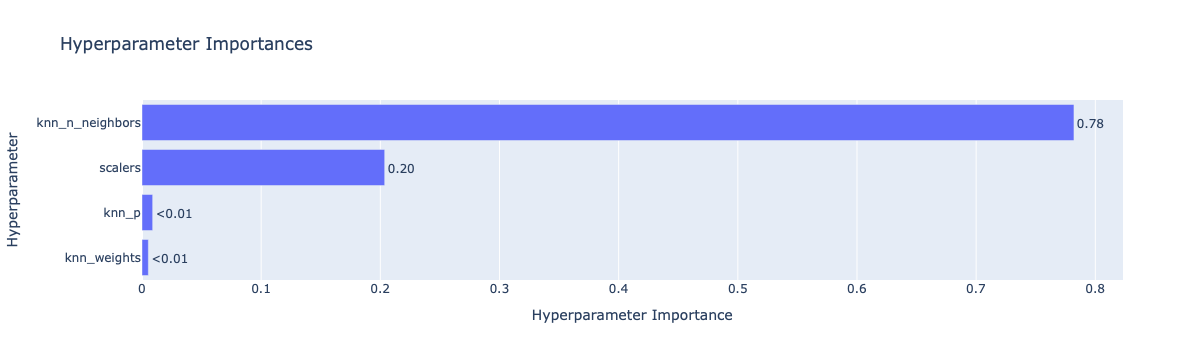

In [12]:
optuna.visualization.plot_param_importances(
    study, target=lambda t: t.values[0], target_name="mean"
)

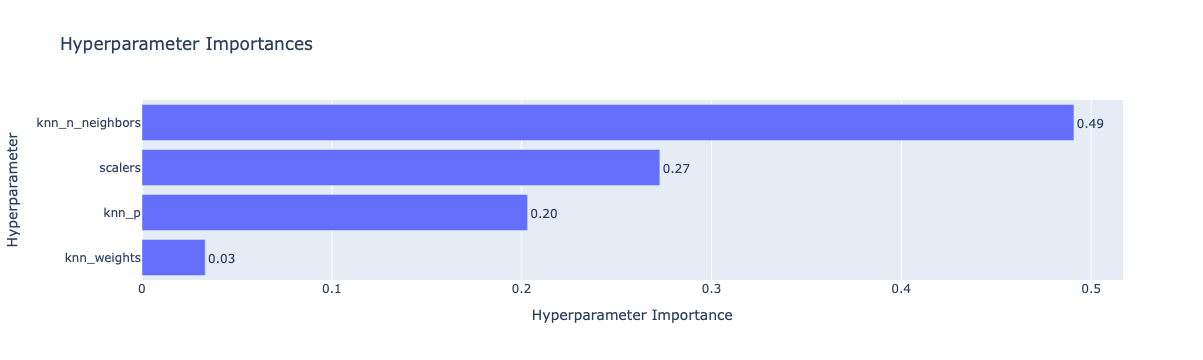

In [13]:
optuna.visualization.plot_param_importances(
    study, target=lambda t: t.values[1], target_name="std"
)

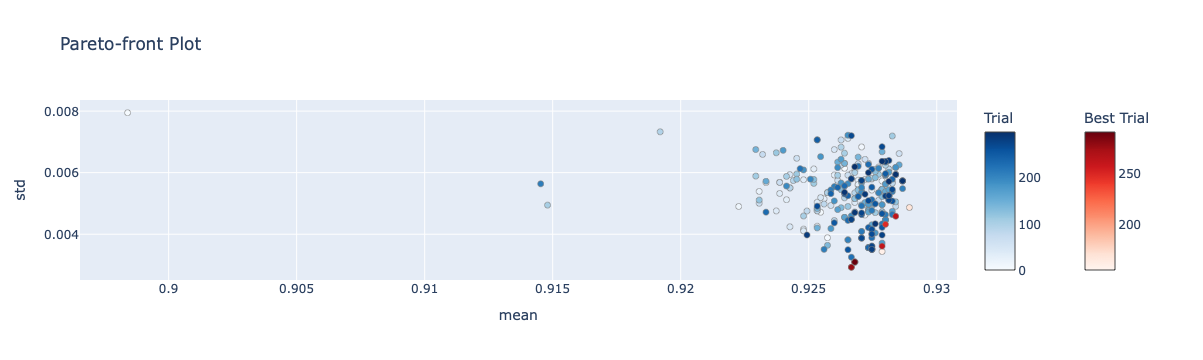

In [29]:
fig = optuna.visualization.plot_pareto_front(
    study,
    target_names=["mean", "std"],
)
show(fig)

In [30]:
print(f"\tparams: {trial_with_highest_accuracy.params}")

	params: {'scalers': 'minmax', 'knn_n_neighbors': 78, 'knn_p': 1, 'knn_weights': 'distance'}


accuracy model train: 1.0
accuracy model test: 0.9285333333333333
accuracy true: 0.9236


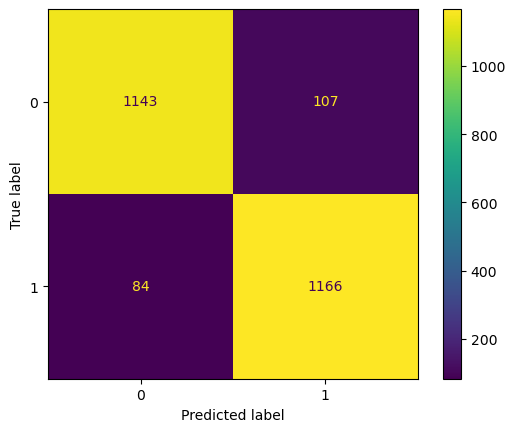

In [31]:
est_78 = KNeighborsClassifier(n_neighbors=78, p = 1, weights='distance')
pipeline = make_pipeline(MinMaxScaler(), est_78)
pipeline.fit(X_train, y_train)
print('accuracy model train:', pipeline.score(X_train, y_train))
print('accuracy model test:' , pipeline.score(X_test, y_test))
pipeline.fit(X, y)
y_predict = pipeline.predict(test)
print('accuracy true:', accuracy_score(y_true, y_predict))
ConfusionMatrixDisplay.from_predictions(y_true, y_predict);

In [32]:
print(f"\tparams: {trial_with_min_std.params}")

	params: {'scalers': 'robust', 'knn_n_neighbors': 20, 'knn_p': 9, 'knn_weights': 'distance'}


accuracy model train: 1.0
accuracy model test: 0.928
accuracy true: 0.9212


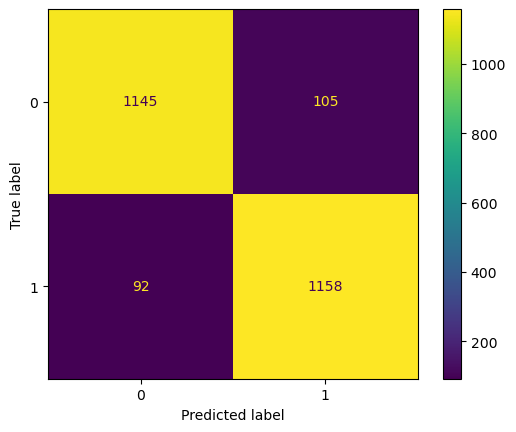

In [33]:
est_20 = KNeighborsClassifier(n_neighbors=20, p = 9, weights='distance')
pipeline = make_pipeline(RobustScaler(), est_20)
pipeline.fit(X_train, y_train)
print('accuracy model train:', pipeline.score(X_train, y_train))
print('accuracy model test:' , pipeline.score(X_test, y_test))
pipeline.fit(X, y)
y_predict = pipeline.predict(test)
print('accuracy true:', accuracy_score(y_true, y_predict))
ConfusionMatrixDisplay.from_predictions(y_true, y_predict);